In [179]:
import pandas as pd
import numpy as np
import requests
import json
import time
import os 

from scripts.vectology_functions import create_aaa_distances, create_pair_distances, embed_text, encode_traits
from nxontology import NXOntology

import seaborn as sns

# Apply the default theme
sns.set_theme()

In [121]:
# files
ebi_data = 'data/UK_Biobank_master_file.tsv'
#efo_nodes = 'data/efo-nodes.tsv'
efo_data = 'data/efo_data.txt.gz'

In [185]:
# get the EBI UKB data
#get ebi data
#url='https://raw.githubusercontent.com/EBISPOT/EFO-UKB-mappings/master/UK_Biobank_master_file.tsv'
#ebi_df = pd.read_csv(url,sep='\t')

ebi_df = pd.read_csv(ebi_data,sep='\t')

#drop some columns
ebi_df = ebi_df[['ZOOMA QUERY','MAPPED_TERM_LABEL','MAPPED_TERM_URI']]
ebi_df.rename(columns={'ZOOMA QUERY':'query'},inplace=True)
print(ebi_df.head())
print(ebi_df.shape)

#create new rows for multiple labels
#ebi_df = (
#        ebi_df.assign(label=ebi_df.MAPPED_TERM_LABEL.str.split("\|\|"))
#        .explode("label")
#        .reset_index(drop=True).drop('MAPPED_TERM_LABEL',axis=1)
#    )

#create new rows for multiple ids
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|\|',',')
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|',',')
ebi_df = (
        ebi_df.assign(id=ebi_df.MAPPED_TERM_URI.str.split(","))
        .explode("id")
        .reset_index(drop=True).drop('MAPPED_TERM_URI',axis=1)
    )

#clean up
ebi_df['id'] = ebi_df['id'].str.strip()

#drop cases where query and id are the same
ebi_df.drop_duplicates(subset=['query','id'],inplace=True)
print(ebi_df.shape)

#drop nan
ebi_df.dropna(inplace=True)
print(ebi_df.shape)
print(ebi_df.head())


                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            MAPPED_TERM_URI  
0  EFO_0004264, EFO_0009431  
1               EFO_0004616  
2               EFO_0003778  
3               EFO_0003901  
4               EFO_0004247  
(1565, 3)
(1613, 3)
(1600, 3)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4       

In [133]:
%%time

# get EFO node data
#efo_df=pd.read_csv(efo_nodes,sep='\t',names=['name','label','type'])
#print(efo_df.head())
#print(efo_df.shape)

# EFO data
efo_df = pd.read_json(efo_data)
#print(efo_df.head())
node_data = []
for i,rows in efo_df.iterrows():
    node_data.append({
        'id':rows['child']['value'],
        'name':rows['childLabel']['value'],
    })
    node_data.append({
        'id':rows['parent']['value'],
        'name':rows['parentLabel']['value'],
        
    })
efo_node_df = pd.DataFrame(node_data)
efo_node_df.drop_duplicates(inplace=True)
print(efo_node_df)

                                              id  \
0           http://www.ebi.ac.uk/efo/EFO_0004285   
1      http://purl.obolibrary.org/obo/HP_0000093   
2           http://www.ebi.ac.uk/efo/EFO_0004207   
3      http://purl.obolibrary.org/obo/HP_0000545   
4           http://www.ebi.ac.uk/efo/EFO_0002608   
...                                          ...   
53112  http://purl.obolibrary.org/obo/HP_0002840   
53114  http://purl.obolibrary.org/obo/PO_0030015   
53118  http://purl.obolibrary.org/obo/EO_0007068   
53120  http://purl.obolibrary.org/obo/HP_0002313   
53124   http://purl.obolibrary.org/obo/FMA_24984   

                                      name  
0                              albuminuria  
1                              Proteinuria  
2                      pathological myopia  
3                                   Myopia  
4                            AIDS dementia  
...                                    ...  
53112                        lymphadenitis  
53114  sporophy

In [168]:
#check all terms in EBI data set are in EFO node data
efo_node_ids = list(efo_node_df['id'])
ebi_ids = list(ebi_df['id'])
missing=[]
matched = []
for i in ebi_ids:
    match = False
    for s in efo_node_ids:
        if i in s and match == False:
            matched.append(s)
            match = True
    if match == False:
        missing.append(i)
print('Missing:',len(missing),missing)

# remove missing from ukb data
print(ebi_df.shape)
for i in missing:
    ebi_df = ebi_df.drop(ebi_df[ebi_df['id'].str.contains(i)].index)
ebi_df['full_id'] = matched
print(ebi_df.head())
print(ebi_df.shape)


Missing: 0 []
(10, 4)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   
5                                Other mood           mood disorder   

            id                               full_id  
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264  
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616  
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778  
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901  
5  EFO_0004247  http://www.ebi.ac.uk/efo/EFO_0004247  
(10, 4)


In [186]:
# preprocess
process_text=[]
for k,g in ebi_df.groupby(np.arange(len(ebi_df))//20):
    params={'text_list':list(g['query'])}
    process_res = requests.post('http://vectology-api.mrcieu.ac.uk/preprocess',data=json.dumps(params))
    process_text.extend([d['result'].replace('unspecified','').replace('nec','') for d in process_res.json()])
print(len(process_text))
    
ebi_df.loc[:, 'processed'] = process_text
print(ebi_df.head())

1600
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

            id                                 processed  
0  EFO_0004264           vascular disorders of intestine  
1  EFO_0009431           vascular disorders of intestine  
2  EFO_0004616                              gonarthrosis  
3  EFO_0003778  psoriatic and enteropathic arthropathies  
4  EFO_0003901          pain associated with micturition  


In [ ]:
%%time

f='data/ebi-ukb-vec.tsv.gz'
if os.path.exists(f):
    print('Already done')
    ebi_df = pd.read_csv(f,sep='\t')
    #issues with reading vectors from CSV 
    ebi_df['BioSentVec'] = ebi_df['BioSentVec'].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
else:
    ebi_df = encode_traits(trait_df=ebi_df,col='processed',name='BioSentVec',model='BioSentVec')
    ebi_df.to_csv(f,sep='\t',compression='gzip',index=False)
print(ebi_df.head())
print(ebi_df.shape)

In [151]:
%%time

f='data/efo-vec.tsv.gz'
if os.path.exists(f):
    print('Already done')
    efo_df = pd.read_csv(f,sep='\t')
    #issues with reading vectors from CSV 
    efo_df['BioSentVec'] = efo_df['BioSentVec'].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
else:
    efo_df = encode_traits(trait_df=efo_node_df,col='name',name='BioSentVec',model='BioSentVec')
    efo_df.to_csv(f,sep='\t',compression='gzip',index=False)
    
print(efo_df.head())


1000 21865
2000 21865
3000 21865
4000 21865
5000 21865
6000 21865
7000 21865
8000 21865
9000 21865
10000 21865
11000 21865
12000 21865
13000 21865
14000 21865
15000 21865
16000 21865
17000 21865
18000 21865
19000 21865
20000 21865
21000 21865
21865 vectors created
                                          id                 name  \
0       http://www.ebi.ac.uk/efo/EFO_0004285          albuminuria   
1  http://purl.obolibrary.org/obo/HP_0000093          Proteinuria   
2       http://www.ebi.ac.uk/efo/EFO_0004207  pathological myopia   
3  http://purl.obolibrary.org/obo/HP_0000545               Myopia   
4       http://www.ebi.ac.uk/efo/EFO_0002608        AIDS dementia   

                                          BioSentVec  
0  [0.4202117919921875, -0.17832736670970917, -1....  
1  [0.4231119751930237, -0.4265417158603668, -0.9...  
2  [0.39966529607772827, -0.34570133686065674, -0...  
3  [0.5090897083282471, -0.6281495094299316, -1.8...  
4  [0.9064940214157104, 0.29144150018692017, 

In [152]:
#create nxontology network of EFO relationships
def create_efo_nxo() -> NXOntology:
    nxo = NXOntology()
    
    edges = []
    efo_rel_df=pd.read_json(efo_data)
    for i,row in efo_rel_df.iterrows():
        child = row['child']['value']
        parent = row['parent']['value']
        edges.append((parent,child))
    print(edges[0:10])
    nxo.graph.add_edges_from(edges)
    return nxo

efo_nx = create_efo_nxo()
efo_nx.freeze()

[('http://purl.obolibrary.org/obo/HP_0000093', 'http://www.ebi.ac.uk/efo/EFO_0004285'), ('http://purl.obolibrary.org/obo/HP_0000545', 'http://www.ebi.ac.uk/efo/EFO_0004207'), ('http://purl.obolibrary.org/obo/HP_0000726', 'http://www.ebi.ac.uk/efo/EFO_0002608'), ('http://purl.obolibrary.org/obo/HP_0001871', 'http://purl.obolibrary.org/obo/HP_0000132'), ('http://purl.obolibrary.org/obo/HP_0001871', 'http://purl.obolibrary.org/obo/HP_0001873'), ('http://purl.obolibrary.org/obo/HP_0001871', 'http://purl.obolibrary.org/obo/HP_0001915'), ('http://purl.obolibrary.org/obo/HP_0001871', 'http://purl.obolibrary.org/obo/HP_0100727'), ('http://purl.obolibrary.org/obo/HP_0001871', 'http://www.ebi.ac.uk/efo/EFO_0004233'), ('http://purl.obolibrary.org/obo/HP_0001871', 'http://www.ebi.ac.uk/efo/EFO_0004272'), ('http://purl.obolibrary.org/obo/HP_0002017', 'http://purl.obolibrary.org/obo/HP_0002018')]


In [160]:
%%time

#ebi_df['BioSentVec']
v1 = list(ebi_df['BioSentVec'])

v2 = list(efo_df['BioSentVec'])


CPU times: user 11.9 ms, sys: 2.95 ms, total: 14.9 ms
Wall time: 14.4 ms


In [161]:
%%time
# cosine of all against all
dd = create_pair_distances(v1,v2)

Creating distances...
1083 21865
1083
CPU times: user 16.8 s, sys: 208 ms, total: 17 s
Wall time: 17.1 s



EBI: 0 ['Vascular disorders of intestine' 'vascular disease'
 'http://www.ebi.ac.uk/efo/EFO_0004264']
EFO: ['intestine' 'http://purl.obolibrary.org/obo/UBERON_0000160'] 0.2804252118057444
0.09090909090909091

EBI: 1 ['Gonarthrosis' 'osteoarthritis || knee'
 'http://www.ebi.ac.uk/efo/EFO_0004616']
EFO: ['osteoarthritis, knee' 'http://www.ebi.ac.uk/efo/EFO_0004616'] 0.3798582708785416
1.0

EBI: 2 ['Psoriatic and enteropathic arthropathies' 'psoriatic arthritis'
 'http://www.ebi.ac.uk/efo/EFO_0003778']
EFO: ['psoriatic arthritis' 'http://www.ebi.ac.uk/efo/EFO_0003778'] 0.30266145532607436
1.0

EBI: 3 ['Pain associated with micturition' 'dysuria'
 'http://www.ebi.ac.uk/efo/EFO_0003901']
EFO: ['micturition' 'http://purl.obolibrary.org/obo/GO_0060073'] 0.24942213583222916
0.07692307692307693

EBI: 4 ['Other mood' 'mood disorder' 'http://www.ebi.ac.uk/efo/EFO_0004247']
EFO: ['mood disorder' 'http://www.ebi.ac.uk/efo/EFO_0004247'] 0.3103362353129442
1.0

EBI: 5 ['Preterm delivery' 'premature 

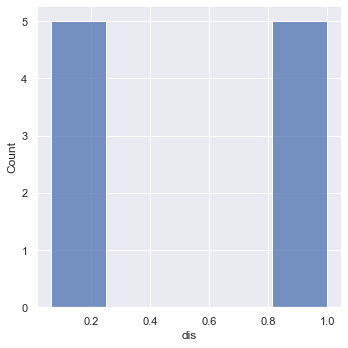

In [184]:
count=0
dis_results=[]
for i,irows in ebi_df.head(n=100).iterrows():
    #print('\nEBI:',count,irows[['query','MAPPED_TERM_LABEL','full_id']].values)
    min_dis = np.nanargmin(dd[count])
    min_val = np.nanmin(dd[count])
    #print('EFO:',efo_df.iloc[min_dis][['name','id']].values,min_val)
    try:
        res = similarity = efo_nx.similarity(irows['full_id'],efo_df.iloc[min_dis]['id']).results()
        #print(res['batet'])
        dis_results.append(res['batet'])
    except:
        print('something wrong')
        exit()
    count+=1
ebi_df['dis']=dis_results
print(ebi_df.head())
sns.displot(ebi_df, x="dis")